In [2]:
#July 13
"""
Starting to look for a general LF for many wavelengths (Optical and UV).
"""

import ares
import numpy as np
import matplotlib.pyplot as pl

In [58]:
data = ares.analysis.GalaxyPopulation() #for lit values
pop_halo = ares.populations.HaloPopulation()


### Star-forming galaxies, 
good approximation to generate their spectra assuming they’ve been forming stars at a constant rate for quite awhile. 

In [6]:
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(pop_sed='eldridge2009', pop_tsf=12)

pop = ares.populations.GalaxyPopulation(**base_pars)

pop_sed='eldridge2009', for example, the src attribute in your GalaxyHOD class will make this assumption, and the method L_per_sfr will return the luminosity (at some wavelength you specify) of a constant SFR population with an age set by the pop_tsf parameter (in Myr).

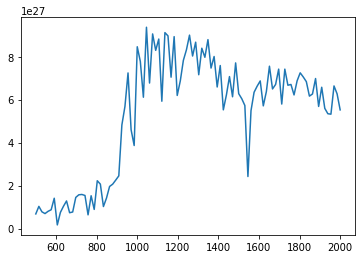

In [54]:
wavelength = np.linspace(500, 2000, 100)

L = [pop.src.L_per_sfr(l) for l in wavelength]
#L_per_sfr : [erg / s / Hz / (Msun / yr)]

pl.plot(wavelength, L)

#do I need to convert to abs Mag? and how do I know z or distance then??

In [55]:
def getParams(z):

    logM_0 = 11.88 #(0.01)
    mu = 0.019 #(0.002)
    N_0 = 0.0282 #(0.0003)
    nu = -0.72 #(0.06)
    gamma_0 = 0.556 #0.001
    gamma_1 = -0.26 #(0.05)
    beta_0 = 1.06 #(0.06)
    beta_1 = 0.17 #(0.12)

    #Redshift-dependent parameterizations
    N = N_0 * (z + 1)**nu
    M_1 = 10**(logM_0*(z+1)**mu)
    beta = beta_1*z+beta_0
    gamma = gamma_0*(z + 1)**gamma_1
    
    return N, M_1, beta, gamma

$L_{per SFR} * SFR(z, Sm) = Lum $   [erg/s/Hz]

then bin Lum --> $\phi(M_{\#})$ [mag$^{-1}$cMpc$^{-3}$]

$\frac{dM_h}{dLum} \cdot \frac{dn}{dM_h} = \phi(M_{\#})$, how to get $\frac{dM_h}{dLum}$ ??

I could get $\frac{dLum}{dM_s}$ maybe? 

In [69]:
# finite difference of Lum wrt M
def finite_dif(Lum, Sm):

    diff = []
    for i in range(len(Lum)-1):
        diff.append( (Lum[i+1] - Lum[i])/(Sm[i+1] - Sm[i]) )
    return diff


def dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio):
    
    n2 = (-beta)*(pop_halo.halos.tab_M**(-beta-1)/M_1**(-beta)) + gamma*(pop_halo.halos.tab_M**(gamma-1)/M_1**(gamma))
    
    dydx = mM_ratio - pop_halo.halos.tab_M * 2 * N * n2 * ( (pop_halo.halos.tab_M/M_1)**(-beta) + \
                                                            (pop_halo.halos.tab_M/M_1)**(gamma) )**(-2) 

    return dydx


def dL_dM(z, Lum, Sm):
    
    N, M_1, beta, gamma = getParams(z)
    mM_ratio = np.log10( 2*N / ( (pop_halo.halos.tab_M/M_1)**(-beta) + (pop_halo.halos.tab_M/M_1)**(gamma) ) )#equ 2

    #this doesn't work as this is a very different length -  need it for only the sm values
    dmdM = dm_dM(pop_halo, N, M_1, beta, gamma, mM_ratio)
    
    dLdm = finite_dif(Lum, Sm)
    
    return dLdm / dmdM[:-1]

def SM_fromHM(z):
    """
    Using the SMHM ratio, given a halo mass, returns the corresponding stellar mass
    """
    
    N, M_1, beta, gamma = getParams(z)
    haloMass = pop_halo.halos.tab_M

    mM_ratio = np.log10( 2*N / ( haloMass/M_1**(-beta) + (haloMass/M_1)**(gamma) ) ) #equ 2

    StellarMass = mM_ratio + np.log10(haloMass)

    return StellarMass

[-16.27157762 -16.27157762 -16.27157762 ... -16.27157762 -16.27157762
 -16.27157762]
[nan nan nan ... nan nan nan]


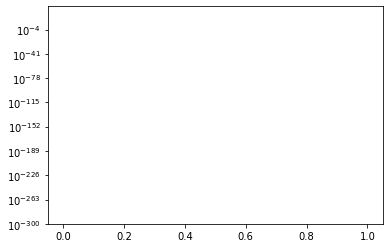

In [71]:
# pop.SFR(z, Sm) or pop.SFRD(Zs)?
# would multiplying by one of these get the LF?
lamda = 1600
z = 1

Sm = SM_fromHM(z)
print(Sm)

# Sm = np.linspace(8, 13, 50)
# [erg / s / Hz / (Msun / yr)] * (Msun)
Lum = pop.src.L_per_sfr(lamda) * pop.SFR(z, Sm)  #[erg/s/Hz]


# * pop.StellarMassFunction(z, Sm)

dLdM = dL_dM(z, Lum, Sm)
print(dLdM)

MagSys = ares.util.MagnitudeSystem()

mag = MagSys.L_to_MAB(Lum, z=z)


print(mag)


#but then 1 wavelength only gives one mag -> can't make a LF for only 1 wavelength

pl.semilogy(mag, pop.StellarMassFunction(z, Sm))

In [49]:
lamda = 1600
z = 1
Sm = np.linspace(8, 13, 50)
# Sm = [12]

something2 = [pop.StellarMassFunction(z, Sm) / (pop.src.L_per_sfr(lamda) * pop.SFR(z, Sm)) for lamda in wavelength]

# MagSys = ares.util.MagnitudeSystem()

mag = [MagSys.L_to_MAB(L = pop.src.L_per_sfr(lamda), z=z) for lamda in wavelength]
# print(mag)
#but then 1 wavelength only gives one mag -> can't make a LF for only 1 wavelength
# print(something2)

# pl.plot(mag, something2[:][0])

### Quiescent galaxies  
    To start, perhaps we could parameterize this age in some simple way: 
        ○ assume that the quenching time (or redshift) is a gaussian? 
		○ Would allow us to say, for a galaxy in a halo of some mass Mh, there’s an X% probability that it quenched at redshift z. 
		○ Naturally give rise to a distribution of ages, which could be generalized to allow for an mh-dep quenching distribution.
